Исламова Сания Маратовна
НПИмд-01-24
(студ. билет 1132249576)

Задачи: 

Установить tensorflow 2. 

Создать трансформерную сеть для определения местоположения объектов относительно друг друга.
Сделать возможность сравнения (как в VQA) местоположения объектов друг с другом.
Relational reasoning – датасет CLEVR.

Зарегистрировать GitHub аккаунт.



Установка и проверка версии Tensorflow

In [1]:
#Установка Tensorflow 2
# pip install tensorflow / conda install tensorflow

#Проверка установки и версии tensorflow
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.17.0


Импорт и загрузка данных 

In [3]:
#Импорт необходимых библиотек
import tensorflow as tf
from tensorflow.keras import layers
import json
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Указываем путь к датасету CLEVR, который скачан на ноутбук (датасет без изображений)
path_to_dataset = "C:\\Users\\4eka0\\Downloads\\CLEVR\\questions\\CLEVR_train_questions.json"

# Загрузка JSON-файла
with open(path_to_dataset, 'r') as f:
    clevr_data = json.load(f)

questions = clevr_data['questions']
print(f"Всего вопросов в датасете: {len(questions)}")

Всего вопросов в датасете: 699989


Выбор случайных вопросов и подготовка данных

In [7]:
# Выбор случайных 1000 вопросов для обучения
random.shuffle(questions)
train_data = questions[:1000]

# Подготовка вопросов и ответов
all_questions = [q['question'] for q in train_data]
all_answers = [q['answer'] for q in train_data]

# Преобразование ответов в числовой формат
unique_answers = list(set(all_answers))
answer_to_index = {ans: i for i, ans in enumerate(unique_answers)}
indexed_answers = [answer_to_index[ans] for ans in all_answers]

# Токенизация текстов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_questions)
sequences = tokenizer.texts_to_sequences(all_questions)
word_index = tokenizer.word_index

# Паддинг последовательностей
max_len = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Преобразование ответов в numpy массив
y_train = np.array(indexed_answers)

Создание трансформерной модели

In [21]:
def build_transformer_model(vocab_size, max_len, num_classes):
    inputs = layers.Input(shape=(max_len,))
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)

    # Трансформерная часть
    x = layers.MultiHeadAttention(num_heads=4, key_dim=128)(embedding, embedding)
    x = layers.LayerNormalization()(x + embedding)
    x = layers.GlobalAveragePooling1D()(x)

    # Классификация
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Создание модели
model = build_transformer_model(vocab_size=len(word_index) + 1, max_len=max_len, num_classes=len(unique_answers))

# Компиляция модели
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
model.fit(padded_sequences, y_train, epochs=30, batch_size=32)

Epoch 1/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1730 - loss: 2.7975
Epoch 2/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2859 - loss: 2.2755
Epoch 3/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3489 - loss: 1.6901
Epoch 4/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4270 - loss: 1.4958
Epoch 5/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4424 - loss: 1.4335
Epoch 6/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4442 - loss: 1.2815
Epoch 7/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4726 - loss: 1.1871
Epoch 8/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4827 - loss: 1.1892
Epoch 9/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5237 - loss: 1.1319
Epoch 10/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5526 - loss: 1.0643
Epoch 11/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5328 - loss: 1.0515
Epoch 12/30
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy:

Тестирование модели на 10 случайных вопросах

In [23]:
# Функция для тестирования и визуализации
def test_model(model, tokenizer, questions, answers, num_samples=10):
    # Выбор случайных вопросов
    random_questions = random.sample(list(zip(questions, answers)), num_samples)
    for i, (question, answer) in enumerate(random_questions):
        sequence = tokenizer.texts_to_sequences([question])
        padded = pad_sequences(sequence, maxlen=max_len)
        prediction = model.predict(padded)
        predicted_answer = unique_answers[np.argmax(prediction)]
        
        print(f"Вопрос {i + 1}: {question}")
        print(f"Реальный ответ: {answer}")
        print(f"Предсказанный ответ: {predicted_answer}")
        print("-" * 50)

# Тестирование модели
test_model(model, tokenizer, all_questions, all_answers)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Вопрос 1: There is a green rubber object in front of the green thing to the left of the small matte thing that is in front of the large metallic cylinder; how big is it?
Реальный ответ: small
Предсказанный ответ: small
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Вопрос 2: How many other things are the same material as the tiny red cube?
Реальный ответ: 1
Предсказанный ответ: 1
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Вопрос 3: Is the number of large green matte spheres that are left of the small brown thing less than the number of cubes right of the green rubber ball?
Реальный ответ: no
Предсказанный ответ: yes
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Вопрос 4: What number of tiny brown things have the same shape as the green object?
Реальный ответ: 0
Предсказанный ответ: 0
-----------------------------------

Визуализация внимания

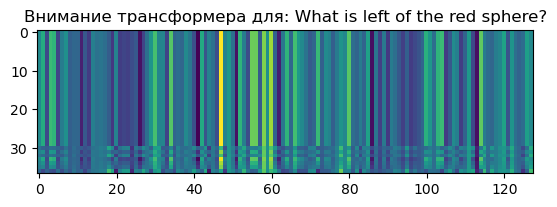

In [25]:
def visualize_attention(model, sentence, tokenizer):
    sequence = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(sequence, maxlen=max_len)

    # Получение внимания
    attention_layer = model.layers[2]  # MultiHeadAttention слой
    attention_output = tf.keras.Model(inputs=model.input, outputs=attention_layer.output)
    attention_weights = attention_output(padded)

    plt.imshow(attention_weights[0].numpy(), cmap='viridis')
    plt.title(f"Внимание трансформера для: {sentence}")
    plt.show()

# Пример визуализации внимания
example_question = "What is left of the red sphere?"
visualize_attention(model, example_question, tokenizer)

Регистрация аккаунта на GitHub

Ссылка на акканут на GitHub:
https://github.com/SaniyaIslamova26/LPforAI/tree/main